In [30]:
import numpy as np
import pandas as pd
import matplotlib as plt
import urllib.request
from pulp import *
from scipy import optimize
import math
import seaborn as sns

%matplotlib inline

In [31]:
t = pd.read_csv('../result/slope.csv', index_col=0).T
v = pd.DataFrame(pd.read_excel('../result/lac.xlsx').mean()).T
v.columns = t.columns
slope = pd.concat([t, v])
slope = slope.rename(index={0:'Lactate'})
slope = pd.concat([slope, pd.DataFrame(
    [21.78, 12.8, 16.84]
    , columns=['Doubling Time'] , index=slope.columns).T])

In [32]:
slope

,Control,Clone A,Clone B
Glucose,0.082599,0.041715,0.013963
Glutamate,0.016972,-0.005134,0.011682
Lactate,0.636289,3.734983,1.916520
Doubling Time,21.780000,12.800000,16.840000


In [33]:
Lac = np.array(slope.T['Lactate']/slope.T.mean()['Lactate'])
gr = np.array([np.log(2)/i for i in slope.T['Doubling Time']])
Gr = gr/gr.mean()

In [34]:
t = pd.read_csv('../csv/stochastic_matrix.csv', index_col=0).fillna(0)

In [35]:
v = t.T[[
    'R00200', 'R00268', 'R00341', 'R00342', 'R00351',
    'R00405', 'R00658', 'R00703', 'R01015', 'R01049',
    'R01056', 'R01061', 'R01070', 'R01082', 'R01196', 
    'R01197', 'R01325', 'R01512', 'R01518', 'R01528',
    'R01529', 'R01641', 'R01786', 'R01830', 'R01899',
    'R01900', 'R02035', 'R02164', 'R02740', 'R04779'
]].T

for i in v.columns:
    if sum(v[i] == 0) == v.shape[0]:
        v = v.drop(i, axis=1)
        
v['C00007'] = pd.Series(np.zeros(v.shape[0]), index=v.index)
v['C00033'] = pd.Series(np.zeros(v.shape[0]), index=v.index)
v['C00092'] = pd.Series(np.zeros(v.shape[0]), index=v.index)
v['C00014'] = pd.Series(np.zeros(v.shape[0]), index=v.index)
v['C00025'] = pd.Series(np.zeros(v.shape[0]), index=v.index)

In [36]:
df = v.T
df['Glucose_input'] =  pd.Series(np.zeros(df.shape[0]), index=df.index)
df['Glucose_input']['C00267'] = 1

df['Oxygen_input'] =  pd.Series(np.zeros(df.shape[0]), index=df.index)
df['Oxygen_input']['C00007'] = 1

df['CO2_output'] =  pd.Series(np.zeros(df.shape[0]), index=df.index)
df['CO2_output']['C00011'] = -1

df['Lactate_output'] =  pd.Series(np.zeros(df.shape[0]), index=df.index)
df['Lactate_output']['C00186'] = -1

df['Acetate_output'] =  pd.Series(np.zeros(df.shape[0]), index=df.index)
df['Acetate_output']['C00033'] = -1

df['Glutamate_input'] =  pd.Series(np.zeros(df.shape[0]), index=df.index)
df['Glutamate_input']['C00025'] = 1

df['Ammonia_input'] =  pd.Series(np.zeros(df.shape[0]), index=df.index)
df['Ammonia_input']['C00014'] = 1

df['Glu_Exchange'] =  pd.Series(np.zeros(df.shape[0]), index=df.index)
df['Glu_Exchange']['C00267'] = -1
df['Glu_Exchange']['C00092'] = 1

df['acetyl_CoA_hydrolase'] =  pd.Series(np.zeros(df.shape[0]), index=df.index)
df['acetyl_CoA_hydrolase']['C00024'] = -1
df['acetyl_CoA_hydrolase']['C00001'] = -1
df['acetyl_CoA_hydrolase']['C00010'] = 1
df['acetyl_CoA_hydrolase']['C00033'] = 1

df['NADP_Exchange'] =  pd.Series(np.zeros(df.shape[0]), index=df.index)
df['NADP_Exchange']['C00005'] = -1
df['NADP_Exchange']['C00003'] = -1
df['NADP_Exchange']['C00006'] = 1
df['NADP_Exchange']['C00004'] = 1

df['ADP_Exchange'] =  pd.Series(np.zeros(df.shape[0]), index=df.index)
df['ADP_Exchange']['C00002'] = -1
df['ADP_Exchange']['C00008'] = 1

df['AMP_Exchange'] =  pd.Series(np.zeros(df.shape[0]), index=df.index)
df['AMP_Exchange']['C00002'] = -1
df['AMP_Exchange']['C00020'] = -1
df['AMP_Exchange']['C00008'] = 2

df['R00835'] =  pd.Series(np.zeros(df.shape[0]), index=df.index)
df['R00835']['C00092'] = -1
df['R00835']['C00006'] = -1
df['R00835']['C01236'] = 1
df['R00835']['C00005'] = 1
df['R00835']['C00080'] = 1

df['R08575'] =  pd.Series(np.zeros(df.shape[0]), index=df.index)
df['R08575']['C05382'] = -1
df['R08575']['C00118'] = -1
df['R08575']['C00279'] = 1
df['R08575']['C00085'] = 1

df['R02164']['C00004'] = -1
df['R02164']['C00003'] = 1
df['R02164']['C15602'] = 0
df['R02164']['C15603'] = 0

df['R00243'] =  pd.Series(np.zeros(df.shape[0]), index=df.index)
df['R00243']['C00025'] = -1
df['R00243']['C00003'] = -1
df['R00243']['C00001'] = -1

df['R00243']['C00026'] = 1
df['R00243']['C00014'] = 1
df['R00243']['C00004'] = 1
df['R00243']['C00080'] = 1

df['Oxophos'] =  pd.Series(np.zeros(df.shape[0]), index=df.index)
df['Oxophos']['C00004'] = -2
df['Oxophos']['C00007'] = -1
df['Oxophos']['C00008'] = -5
df['Oxophos']['C00002'] = 5
df['Oxophos']['C00003'] = 2
df['Oxophos']['C00011'] = 1

In [37]:
BIOMASS = pd.read_csv('../csv/amino_acid.csv',index_col=0)
df_Biomass =  pd.Series(np.zeros(df.shape[0]), index=df.index)

for i in BIOMASS.index:
    df_Biomass[BIOMASS.T[i]['C_num']] = BIOMASS.T[i]['flux']
    
df_Biomass['C00668'] = -0.27519
df_Biomass['C00119'] = (-0.039036) + (-0.036117) + (-0.053446)

In [63]:
BIOMASS

,flux,C_num
3PG,-0.977991,C00197
ADP,22.800180,C00008
ATP,-22.800180,C00002
Accetate,0.046571,C00033
Acetyl-CoA,-0.046571,C00024
CO2,-0.359260,C00011
CoA,0.046571,C00010
Fum,0.359260,C00122
NAD,-0.977991,C00003
NADH,0.977991,C00004


In [38]:
df_new = pd.concat([df_Biomass.T, df], axis=1)
df_new = df_new.rename(columns={0: 'BIOMASS'})
df_new = df_new.drop([
    'C00001','C00009','C00080','C00138','C00139','C15602','C15603'
])

In [39]:
def fba(glc, glu, ox):
    x = []
    for i in df_new.columns:
        if (
                (i=='Oxophos') or (i=='R01899') or (i=='R00268') or (i=='R10343') or (i=='R02164') or (i=='R00835') or 
                (i=='R02035') or (i=='ATP_Exchange') or (i=='AMP_Exchange') or (i=='CO2_output')
        ):
            x.append(LpVariable(i, lowBound=0,upBound=10000, cat='Continuous'))

        elif (i=='Lactate_output'):
            x.append(LpVariable(i, lowBound=0, upBound=10000, cat='Continuous'))
            
        elif (i=='BIOMASS'):
            x.append(LpVariable(i, lowBound=0, upBound=100, cat='Continuous'))
        
        elif (i=='Oxygen_input'):
            x.append(LpVariable(i, lowBound=ox, upBound=ox, cat='Continuous'))
        
        elif (i=='Glucose_input'):
            x.append(LpVariable(i, lowBound=glc, upBound=glc, cat='Continuous'))

        elif (i=='Glutamate_input'):
            x.append(LpVariable(i, lowBound=glu, upBound=glu, cat='Continuous'))
            
        elif (i=='Ammonia_input'):
            x.append(LpVariable(i, lowBound=-10000, upBound=10000, cat='Continuous'))
              
        elif (
            (i=='Succinate_output') or (i=='Malate_output') or (i=='Fumarate_output') or (i=='Acetate_output')
        ):
            x.append(LpVariable(i, lowBound=0, upBound=50, cat='Continuous'))
                
        elif (i=='R00200') or (i=='R01196') or (i=='R01197') or (i=='R00405'):
            x.append(LpVariable(i, lowBound=-10000, upBound=0, cat='Continuous'))

        else:
            x.append(LpVariable(i, lowBound=-10000, upBound=10000, cat='Continuous'))

    m = LpProblem(sense=LpMaximize)
    m += x[0]

    for i in np.dot(df_new, x):
        m += i == 0

    status = m.solve()
    if (LpStatus[status]) == 'Infeasible':
        print(i)
        return 100, 100

    y = []
    for i in x:
        y.append(i.value())

    j = pd.DataFrame(y, index=[str(i) for i in x]).T
    
    return np.array([j['BIOMASS'][0], j['Lactate_output'][0]])

In [40]:
def f(x):
    x1, x2, x3, y1, y2, y3, z1, z2, z3 = x
    h =[
        fba(x1, y1, z1), 
        fba(x2, y2, z2), 
        fba(x3, y3, z3)    
    ]
    
    p = pd.DataFrame(h, index=['Con', 'CloneA', 'CloneB'], columns=['Biomass', 'Lactate'])
    v = np.sum((p['Biomass']/p['Biomass'].mean() - Gr)**2) + np.sum((p['Lactate']/p['Lactate'].mean() - Lac)**2)
    
    return v

In [41]:
x = list(slope.loc['Glucose'].values)+list(slope.loc['Glutamate'].values)+[0.01 for i in range(0, 3)]

In [42]:
x

[0.08259861766669982,
 0.0417153031955904,
 0.01396340408687743,
 0.016971667782344144,
 -0.005133519350589648,
 0.011681551754142924,
 0.01,
 0.01,
 0.01]

In [43]:
res1 = optimize.minimize(
    f, 
    x,
    method='Nelder-Mead'
)

Glutamate_input - R00243
Glutamate_input - R00243
Glutamate_input - R00243
Glutamate_input - R00243
Glutamate_input - R00243
Glutamate_input - R00243
Glutamate_input - R00243
Glutamate_input - R00243
Glutamate_input - R00243
Glutamate_input - R00243
Glutamate_input - R00243
Glutamate_input - R00243
Glutamate_input - R00243
Glutamate_input - R00243
Glutamate_input - R00243
Glutamate_input - R00243
Glutamate_input - R00243
Glutamate_input - R00243
Glutamate_input - R00243
Glutamate_input - R00243
Glutamate_input - R00243


In [44]:
res1

 final_simplex: (array([[ 0.00277818,  0.0523899 ,  0.01890464,  0.01624794, -0.00207968,
         0.01469146,  0.00707023,  0.01854966,  0.00913931],
       [ 0.00278706,  0.05237048,  0.01889666,  0.01622368, -0.00207454,
         0.01471015,  0.00708333,  0.01855536,  0.00913953],
       [ 0.00272192,  0.05234442,  0.01890595,  0.01622871, -0.00208724,
         0.0147045 ,  0.00704958,  0.01855568,  0.00915482],
       [ 0.00269964,  0.05243205,  0.01889413,  0.01621087, -0.00209998,
         0.01468446,  0.00706433,  0.01854031,  0.0091619 ],
       [ 0.0027614 ,  0.05236324,  0.01886464,  0.01619376, -0.00208054,
         0.0147103 ,  0.00711896,  0.01854228,  0.00916445],
       [ 0.00271534,  0.05239433,  0.0188682 ,  0.01617762, -0.002066  ,
         0.01472773,  0.00711144,  0.01857097,  0.00915279],
       [ 0.00274135,  0.05247432,  0.01884818,  0.01616606, -0.00206725,
         0.01472112,  0.00708901,  0.01858807,  0.00916361],
       [ 0.00283355,  0.05238671,  0.01888612

In [45]:
x1, x2, x3, y1, y2, y3, z1, z2, z3 = res1.x

In [46]:
def fba_result(glc, glu, ox):
    x = []
    for i in df_new.columns:
        if (
                (i=='Oxophos') or (i=='R01899') or (i=='R00268') or (i=='R10343') or (i=='R02164') or (i=='R00835') or (i=='R02035') or
                (i=='ATP_Exchange') or (i=='AMP_Exchange') or (i=='Glutamate_output') or (i=='CO2_output') or (i=='Ammonia_output')
        ):
            x.append(LpVariable(i, lowBound=0,upBound=10000, cat='Continuous'))

        elif (i=='Lactate_output'):
            x.append(LpVariable(i, lowBound=0, upBound=10000, cat='Continuous'))
            
        elif (i=='BIOMASS'):
            x.append(LpVariable(i, lowBound=0, upBound=100, cat='Continuous'))
        
        elif (i=='Oxygen_input'):
            x.append(LpVariable(i, lowBound=ox, upBound=ox, cat='Continuous'))
        
        elif (i=='Glucose_input'):
            x.append(LpVariable(i, lowBound=glc, upBound=glc, cat='Continuous'))

        elif (i=='Glutamate_input'):
            x.append(LpVariable(i, lowBound=glu, upBound=glu, cat='Continuous'))
            
        elif (i=='Ammonia_input'):
            x.append(LpVariable(i, lowBound=-10000, upBound=10000, cat='Continuous'))
              
        elif (
            (i=='Succinate_output') or (i=='Malate_output') or (i=='Fumarate_output') or (i=='Acetate_output')
        ):
            x.append(LpVariable(i, lowBound=0, upBound=50, cat='Continuous'))
                
        elif (i=='R00200') or (i=='R01196') or (i=='R01197') or (i=='R00405'):
            x.append(LpVariable(i, lowBound=-10000, upBound=0, cat='Continuous'))

        else:
            x.append(LpVariable(i, lowBound=-10000, upBound=10000, cat='Continuous'))

    m = LpProblem(sense=LpMaximize)
    m += x[0]

    for i in np.dot(df_new, x):
        m += i == 0

    status = m.solve()
    if (LpStatus[status]) == 'Infeasible':
        print(i)
        return

    y = []
    for i in x:
        y.append(i.value())

    j = pd.DataFrame(y, index=[str(i) for i in x]).T
    
    return j

In [47]:
res1.x

array([ 0.00277818,  0.0523899 ,  0.01890464,  0.01624794, -0.00207968,
        0.01469146,  0.00707023,  0.01854966,  0.00913931])

In [48]:
result = pd.concat([fba_result(x1, y1, z1).T, fba_result(x2, y2, z2).T, fba_result(x3, y3, z3).T], axis=1)
result.columns = ['Control', 'Clone A', 'Clone B']

In [59]:
# result.to_csv('../result/__fba__.csv')

In [50]:
result

,Control,Clone A,Clone B
BIOMASS,0.001752,0.002984,0.002265
R00200,-0.015194,-0.091441,-0.043956
R00268,0.000000,0.006507,0.000000
R00341,0.012541,-0.008394,0.009900
R00342,0.014278,0.001072,0.012145
R00351,0.000000,-0.006507,0.000000
R00405,-0.013648,0.000000,-0.011331
R00658,0.002653,0.099835,0.034056
R00703,-0.014308,-0.083425,-0.042811
R01015,-0.002221,-0.051441,-0.018184


In [51]:
result.loc['BIOMASS']/result.loc['BIOMASS'][0]

Control    1.000000
Clone A    1.703233
Clone B    1.292645
Name: BIOMASS, dtype: float64

In [52]:
result.loc['Lactate_output']/result.loc['Lactate_output'][0]

Control    1.000000
Clone A    5.830664
Clone B    2.992091
Name: Lactate_output, dtype: float64

In [53]:
result.loc['Glucose_input']/result.loc['Glucose_input'][0]

Control     1.000000
Clone A    18.857666
Clone B     6.804698
Name: Glucose_input, dtype: float64

In [54]:
Lac/Lac[0]

array([1.        , 5.86994594, 3.0120277 ])

In [55]:
x = result.loc['Glucose_input'] 
y = result.loc['Oxygen_input'] 

y/x

Control    2.544920
Clone A    0.354069
Clone B    0.483442
dtype: float64

In [56]:
# Control Clone B Clone A
x = result.loc['Lactate_output'] 
y = result.loc['Oxygen_input']

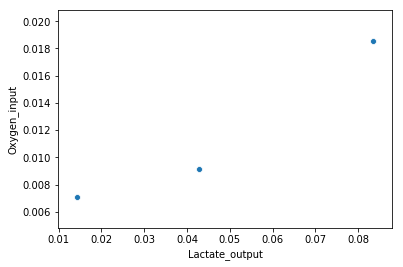

In [57]:
sns.scatterplot(x, y)